This Notebook will find optimal wieghts using MPT, then will back test those wieghts 1 year fowrad from data collections

In [27]:
import time
import os 

start_time = time.time() # measure run time

WORKSPACE_DIR = os.getenv('WORKSPACE_DIR')
if not os.getcwd().endswith('portfolio_py'):
    os.chdir(f'{WORKSPACE_DIR}/portfolio_py')
print(f'Current Working Directory: {os.getcwd()}')


Current Working Directory: /Users/blakeuribe/Desktop/portfolio_py


Get Back Test Dates

In [28]:
from datetime import datetime
from dateutil.relativedelta import relativedelta
from utils.config import PROGRAM_START_DATE, PROGRAM_END_DATE, mpt_stocks_for_profit, mpt_stocks_for_sharpe
from utils.finance_utils import backtest_portfolio, MPTOptimizer, plot_cum_ret

date_obj = datetime.strptime(PROGRAM_END_DATE, "%Y-%m-%d")  # Convert string to datetime objectb
backtest_end = date_obj + relativedelta(years=1)

backtest_start = PROGRAM_END_DATE


Conduct MPT

[*********************100%***********************]  8 of 8 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


--MPT on High Sharpe--


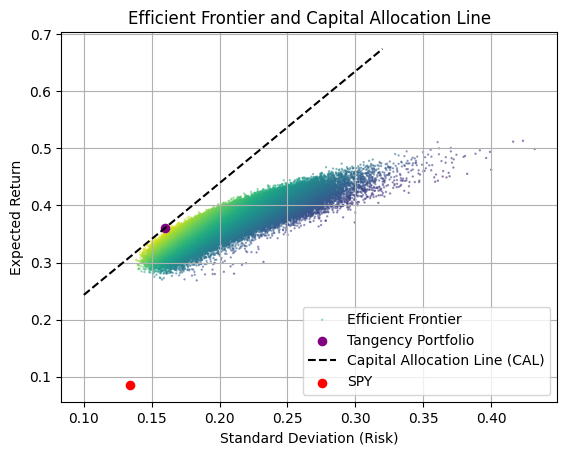

-- Optimal Portfolio (CAL) --
Max Sharpe Ratio: 1.96
Corresponding Return: 0.36
Corresponding Standard Deviation: 0.16
Optimal Weights: {'DE': np.float64(0.018586936243319484), 'NEM': np.float64(0.008715525339243722), 'CQP': np.float64(0.12178930058556854), 'GRMN': np.float64(0.20765931225475093), 'CSCO': np.float64(0.4223198340511742), 'VST': np.float64(0.0643265902034368), 'RCL': np.float64(0.12703615080558459), 'MPLX': np.float64(0.02956635051692186)}


In [29]:
# print('--MPT on High Profit--')
# optimizer_for_high_profit = MPTOptimizer(mpt_stocks_for_profit, start_date=PROGRAM_START_DATE, end_date=PROGRAM_END_DATE)
# optimizer_for_high_profit.simulate_portfolios()
# optimizer_for_high_profit.plot_efficient_frontier()
# tangecy_portfolio_for_profit_stocks = optimizer_for_high_profit.find_tangency_portfolio()

print('\n--MPT on High Sharpe--')
optimizer_for_high_sharpe = MPTOptimizer(mpt_stocks_for_sharpe, start_date=PROGRAM_START_DATE, end_date=PROGRAM_END_DATE)
optimizer_for_high_sharpe.simulate_portfolios()
optimizer_for_high_sharpe.plot_efficient_frontier()
tangecy_portfolio_for_sharpe_stocks = optimizer_for_high_sharpe.find_tangency_portfolio()


In [30]:
import datetime

program_start_date_obj = datetime.datetime.strptime(backtest_start, '%Y-%m-%d')

# Check if the year is less than 2021
if program_start_date_obj.year < 2021:
    print("Will need to use IRX")
    risk_rate_ticker = '^IRX'
else:
    print("we can use sgov")
    risk_rate_ticker = 'SGOV'

we can use sgov


In [31]:
from utils.finance_utils import find_lending_or_borrowing_portfolio


# Benchmark Metrics
spy_return = optimizer_for_high_sharpe.spy_return.iloc[0]
spy_std = optimizer_for_high_sharpe.spy_std.iloc[0]
risk_free_rate = optimizer_for_high_sharpe.risk_free_rate.iloc[0] # Optimizer uses mean rate

# Info for high profit stocks
# stock_weight_dict_profit = tangecy_portfolio_for_profit_stocks[0]
# tangecy_portfolio_metrics_dict_profit = tangecy_portfolio_for_profit_stocks[1]

# Info for high profit stocks
stock_weight_dict_sharpe = tangecy_portfolio_for_sharpe_stocks[0]
tangecy_portfolio_metrics_dict_sharpe = tangecy_portfolio_for_sharpe_stocks[1]


# Find lending or borrowing for 
# portfolio_allocation_high_profit = find_lending_or_borrowing_portfolio(
#     tangecy_portfolio_metrics_dict_profit['Corresponding Return'],
#     tangecy_portfolio_metrics_dict_profit['Corresponding Standard Deviation'],
#     risk_free_rate,
#     spy_std,
#     list(stock_weight_dict_profit.keys()),
#     list(stock_weight_dict_profit.values()),
#     add_margin=True,
#     risk_free_proxy=risk_rate_ticker
#     )

portfolio_allocation_high_sharpe = find_lending_or_borrowing_portfolio(
    tangecy_portfolio_metrics_dict_sharpe['Corresponding Return'],
    tangecy_portfolio_metrics_dict_sharpe['Corresponding Standard Deviation'],
    risk_free_rate,
    spy_std,
    list(stock_weight_dict_sharpe.keys()),
    list(stock_weight_dict_sharpe.values()),
    add_margin=True,
    risk_free_proxy=risk_rate_ticker
    )
portfolio_allocation_high_sharpe


{'Risky Asset Weight': np.float64(0.8382894952657721),
 'Risk-Free Asset Weight': np.float64(0.16171050473422788),
 'Stocks': ['DE', 'NEM', 'CQP', 'GRMN', 'CSCO', 'VST', 'RCL', 'MPLX', 'SGOV'],
 'Stock Weights': array([0.01558123, 0.00730613, 0.10209469, 0.17407862, 0.35402628,
        0.0539243 , 0.10649307, 0.02478516, 0.1617105 ]),
 'Expected Portfolio Return': np.float64(0.3102012919562827),
 'Expected Portfolio Standard Deviation': np.float64(0.13413692573975414),
 'Note': 'Portfolio includes T-bills (expected std > benchmark std).'}

Begin Back Testing

In [ ]:

print('----Begining Back Test----')
print(f'Back Test starts on: {backtest_start}')
print(f'Back Test ends on: {backtest_end}')

paper_value = 100_000
backtest_spy_return = backtest_portfolio(['spy'], 1, [1], start_date=backtest_start, end_date=backtest_end)-1

# Run the backtest
# backtest_on_high_profit = backtest_portfolio(portfolio_allocation_high_profit['Stocks'], paper_value, portfolio_allocation_high_profit['Stock Weights'], start_date=backtest_start, end_date=backtest_end)
backtest_on_high_sharpe = backtest_portfolio(portfolio_allocation_high_sharpe['Stocks'], paper_value, portfolio_allocation_high_sharpe['Stock Weights'], start_date=backtest_start, end_date=backtest_end)

# plot_cum_ret(portfolio_allocation_high_sharpe['Stocks'], portfolio_allocation_high_sharpe['Stock Weights'], start_date='2024-03-01', end_date=backtest_end)
# plot_cum_ret(portfolio_allocation_high_profit['Stocks'], portfolio_allocation_high_profit['Stock Weights'], start_date='2024-03-01', end_date=backtest_end)

[*********************100%***********************]  1 of 1 completed

----Begining Back Test----
Back Test starts on: 2025-03-12
Back Test ends on: 2026-03-12 00:00:00



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Record Results

In [33]:
import pandas as pd
import os

# Define file path
file_path = f"{WORKSPACE_DIR}/portfolio_py/data/clean/backtest_results.csv"

# Check if file exists
if os.path.exists(file_path):
    # Load existing data
    backtest_df = pd.read_csv(file_path)
else:
    # Create a new DataFrame if the file doesn't exist
    backtest_df = pd.DataFrame(columns=[
        "Data_Collection_Start", "Data_Collection_End",
        "Backtest_Start", "Backtest_End",
        "Stock_Selection_Method", 'Stocks', 'Sharpe', "Starting_Value", "Ending_Value"
    ])

# New entries to append
new_entries = [
    # {
    #     "Data_Collection_Start": PROGRAM_START_DATE,
    #     "Data_Collection_End": PROGRAM_END_DATE,
    #     "Backtest_Start": backtest_start,
    #     "Backtest_End": backtest_end,
    #     "Stock_Selection_Method": "High Profit Stocks",
    #     "Stocks": (",".join(portfolio_allocation_high_profit['Stocks'])),
    #     'Sharpe': tangecy_portfolio_for_profit_stocks[1]['Max Sharpe'],
    #     "Starting_Value": paper_value,
    #     "Ending_Value": backtest_on_high_profit,
    #     'SPY Retrun': backtest_spy_return
    # },
    {
        "Data_Collection_Start": PROGRAM_START_DATE,
        "Data_Collection_End": PROGRAM_END_DATE,
        "Backtest_Start": backtest_start,
        "Backtest_End": backtest_end,
        "Stock_Selection_Method": "High Sharpe Ratio Stocks",
        "Stocks": (",".join(portfolio_allocation_high_sharpe['Stocks'])),
        'Sharpe': tangecy_portfolio_for_sharpe_stocks[1]['Max Sharpe'],
        "Starting_Value": paper_value,
        "Ending_Value": backtest_on_high_sharpe,
        'SPY Retrun': backtest_spy_return

    }
]

# Convert new entries to a DataFrame
new_entries_df = pd.DataFrame(new_entries)

# Drop duplicates before writing
backtest_df = pd.concat([backtest_df, new_entries_df], ignore_index=True).drop_duplicates()

# **Append** to the CSV without overwriting
backtest_df.to_csv(file_path, index=False, mode="w")  

print("New rows added successfully (without overwriting)!") 


New rows added successfully (without overwriting)!


In [34]:
backtest_df.tail()

,Data_Collection_Start,Data_Collection_End,Backtest_Start,Backtest_End,Stock_Selection_Method,Stocks,Sharpe,Starting_Value,Ending_Value,SPY Retrun
21,2024-03-12,2025-03-12,2025-03-12,2026-03-12 00:00:00,High Sharpe Ratio Stocks,"DE,NEM,CQP,GRMN,CSCO,VST,RCL,MPLX,SGOV,SPY",1.967301,100000,101023.530188,0.003847
22,2024-03-12,2025-03-12,2025-03-12,2026-03-12 00:00:00,High Profit Stocks,"DE,NEM,CQP,BBVA,EQR,BKNG,AVB,AAPL,SGOV",1.512111,100000,92894.273296,-0.094785
23,2024-03-12,2025-03-12,2025-03-12,2026-03-12 00:00:00,High Sharpe Ratio Stocks,"DE,NEM,CQP,GRMN,CSCO,VST,RCL,MPLX,SGOV",1.970060,100000,90512.009679,-0.094785
24,2024-03-12,2025-03-12,2025-03-12,2026-03-12 00:00:00,High Sharpe Ratio Stocks,"DE,NEM,CQP,GRMN,CSCO,VST,RCL,MPLX,SGOV",1.962145,100000,95497.860457,-0.032437
25,2024-03-12,2025-03-12,2025-03-12,2026-03-12 00:00:00,High Sharpe Ratio Stocks,"DE,NEM,CQP,GRMN,CSCO,VST,RCL,MPLX,SGOV",1.957333,100000,95019.040787,-0.032437


In [66]:

chosen_portfolio = {
    k: float(v) if isinstance(v, np.floating) else
       v.tolist() if isinstance(v, np.ndarray) else
       v
    for k, v in portfolio_allocation_high_sharpe.items() # change this vairble based on your prefeneces, and analysis
}

with open('utils/config.py', 'a') as f:
    f.write('\n# New Entry from backtesting.ipynb')
    f.write(f'\nchosen_portfolio = {chosen_portfolio}\n')